# Sorting an a new experiment (dataset)

We will sort a new experiment using:
- A pre-trained Convolutional AutoEncoder (CAE) for feature extraction
- A Random Forest (RF) for classification

The random forest needs to be trained on a subset of annotated cells.
<br>These cells can come from another experiment, or can correspond to an annotated subset of the current experiment.

<br> **We recommend that at least 200 cells from the same experiment are annotated manually. Then the CAE-RF sorter can be used to annotate the rest.**

## Sorting steps:
1. Loading the dataset(from experiment folder or from .h5 file)
2. Loading a pre-trained CAE and performing feature extraction
3. Training a Random Forest (or use a pre-trained)
4. Sorting the new cells

In this example we will load the dataset from disk
## 1) Loading the dataset

We will load a dataset that we previously saved to an .h5 file.
<br>Alternatively, the dataset can be loaded directly from disk using import_ideas().
<br>The process of loading a dataset and saving it to an .h5 file is documented in **load_experiment.ipynb**.


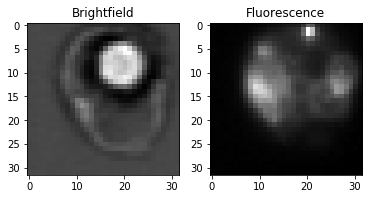

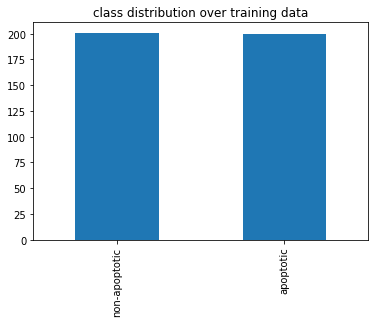

In [31]:
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import re
import h5py
from decafx.cae_architectures import cae_indepIn, get_encoder, cae_encode
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import itertools

#%% load the data from the .h5 file
h5f = h5py.File('./data/X_M4.h5','r')
#h5f.visit(print)#print all filenames in the file
X = h5f['X'][()]#images
y = h5f['y'][()]#labels
fnames = h5f['fnames'][()]
h5f.close()

#plot the image of a cell
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X[0,:,:,0],cmap='gray')
plt.title('Brightfield')
plt.subplot(1,2,2)
plt.imshow(X[0,:,:,1],cmap='gray')
plt.title('Fluorescence')

#plot histogram of class distribution
plt.figure()
s=pd.Series(y).astype('category')#create pandas series
s.cat.rename_categories(['apoptotic','non-apoptotic'],inplace=True)#rename categories
pd.value_counts(s).plot(kind='bar')
plt.title('class distribution over training data')
plt.show()

We can see that apoptotic cells were loaded as class0 (y==0) and non-apoptotic cells were loaded as class1 (y==1)
<br>Let's visualize one apoptotic and one non-apoptotic cell.

## 2) Loading a pre-trained CAE and performing feature extraction

We will now load a pre-trained CAE to extract features from the cell-images.
<br>The process of traing a CAE on unlabeled cells is described in **train_CAE.ipynb**

In [16]:
#load the CAE and extract encoder
nchannels=X.shape[-1]#number of imaging channels (Brightfield, Fluorescence)
net = cae_indepIn(nchannels=nchannels)
net.load_weights('./data/cae_M1.hdf5')
encoder=get_encoder(net)
#print(encoder.summary())
print('Encoding dataset, this might take a while...')
X_enc=cae_encode(X,encoder)
print('Dataset encoded')

Encoding dataset, this might take a while...
Dataset encoded


## 3) Training a Random Forest (or use a pre-trained)

We will randomly split the data into 50% training and 50% test set.
<br> The training set will be used to train a Random Forest classifier to sort the cells of the test set.
<br> We will save the trained Random Forest so that it can be used as a pre-trained sorter to sort future experiments.


accuracy 0.905472636816


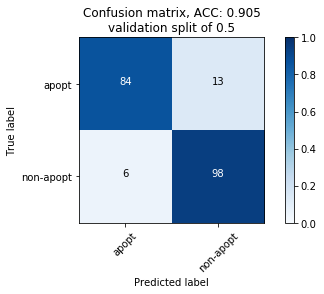

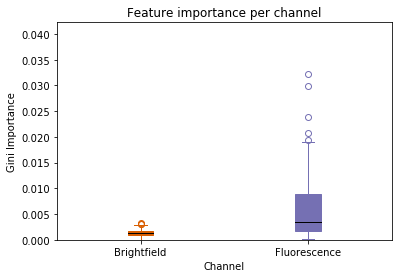

re-training classifer on the entire dataset
classifier saved at ['./sorting_results/test_experimenttrained_classifer.pkl']




original random forest:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


random forest loaded from disk:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


In [54]:
#fix the random seed to get repeatable results
np.random.seed(1)

#symbolic names for the classes to sort into
classes = ['apopt','non-apopt']

#split into a training and test set
test_percentage=0.5#50% test set
X_tr, X_ts, y_tr, y_ts, fnames_tr, fnames_ts = train_test_split(X_enc, y, fnames,
                                                                test_size=test_percentage, random_state=1)

#fit a random forest
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
rf.fit(X=X_tr,y=y_tr)
#predict on the test set
y_pred=rf.predict(X=X_ts)
y_pred_proba=rf.predict_proba(X=X_ts)
y_true=y_ts

#calculate accuracy and confusion matrix
accuracy=sum(y_pred==y_ts)/len(y_ts)
confmat = confusion_matrix(y_ts, y_pred)
confmat_title='Confusion matrix, ACC: '+str(round(accuracy,3))+'\n'+\
'validation split of '+str(round(test_percentage,3))
#save feature importance
feat_imp=rf.feature_importances_
print('accuracy',accuracy)

#where to save all results
path = './sorting_results/test_experiment'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/
    plot_confusion_matrix.html
    """
    
    row_sums=cm.sum(axis=1)
    cm_row_normalized = cm.copy()/row_sums[:,np.newaxis]
    
    #plt.imshow(cm_row_normalized, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    
    #to scale the color of each box to 0-1
    plt.imshow(cm_row_normalized, interpolation='nearest', cmap=cmap,
           vmin=0, vmax=1)
    #plt.colorbar(boundaries=np.linspace(0,1,6,endpoint=True))
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#plot confusion matrix, raw counts but row normalized color
plt.figure()
plot_confusion_matrix(confmat, classes=classes,title=confmat_title)
plt.savefig(path+'_confusion_matrix.png',bbox_inches='tight',dpi=300)

#new plot: boxplots:
cae_BF=feat_imp[0:128]
cae_FL=feat_imp[128:256]
palette=plt.cm.Dark2
notch=False
ylim = (0,np.max([cae_BF.max(),cae_FL.max()])+0.01)
xlim = (-0.5,1.5)
medianprops = 'k'
plt.figure()
c = palette(1)
plt.boxplot(cae_BF, positions=[0], notch=notch, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=medianprops),
            )
c = palette(2)
plt.boxplot(cae_FL, positions=[1], notch=notch, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=medianprops),
            )
plt.ylim(ylim)
plt.xlim(xlim)
plt.ylabel('Gini Importance')
plt.xlabel('Channel')
plt.xticks([0,1],['Brightfield','Fluorescence'])
plt.title('Feature importance per channel')
plt.savefig(path+'_feature_importance.png',bbox_inches='tight',dpi=300)
plt.show()

#now save metadata for the sorted test set
cell_id=[]
for f in fnames_ts:#only keep folders/directories
    numbers = re.findall('\d+', f.decode('utf-8'))
    #numbers[-2] is object id
    #numbers[-1] is channel
    #according to IDEAS naming convention
    cell_id.append(numbers[-2])

#probability of each predicted class
confidence=np.zeros(y_pred_proba.shape[0])
for i in range(y_pred_proba.shape[0]):
    confidence[i] = y_pred_proba[i,y_pred[i]]

#symbolic names for predicted class
y_pred_symbolic=[]
for i in range(y_pred.shape[0]):
    y_pred_symbolic.append(classes[y_pred[i]])

#symbolic name for IDEAS class
y_true_symbolic=[]
for i in range(y_true.shape[0]):
    y_true_symbolic.append(classes[y_true[i]])

res_dict={'cell_id':cell_id, 'label_predicted':y_pred_symbolic,
          'confidence':confidence,'label_IDEAS':y_true_symbolic}

cols=['cell_id','label_predicted', 'confidence','label_IDEAS']

df=pd.DataFrame(res_dict,columns=cols)

#save results to disk as .csv files
#this contains cell IDs, class and confidence
df.to_csv(path+'.csv',index=False)

#this saves one .csv per class, containing the cell IDs of the class
for c in classes:
    #print(c)
    df.loc[df['label_predicted']==c]['cell_id'].to_csv(path+' '+c+'.csv',index=False)

#this saves one .csv per class, containing the cell IDs of the class
for c in classes:
    #print(c)
    #df.loc[df['label_predicted']==c]['cell_id'].to_csv(path+' '+c+'.csv',index=False)
    #export .csv file as .pop to allow integration into IDEAS without renaming
    df.loc[df['label_predicted']==c]['cell_id'].to_csv(path+' '+c+'.pop',index=False)

#train on entire dataset and save trained classifier
print('re-training classifer on the entire dataset')
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
rf.fit(X=X_enc,y=y)#fit again on entire dataset to save trained model
print('classifier saved at',joblib.dump(rf, path+'trained_classifer.pkl'))

#the classifier can be loaded in the future using
rf_from_disk = joblib.load(path+'trained_classifer.pkl')
print('\n')
print('\n')
print('original random forest:\n',rf)
print('\n')
print('random forest loaded from disk:\n',rf_from_disk)